# less stochastic optimizer


# 3. optimization per minibatch


## 3.2. newton(hessian) method

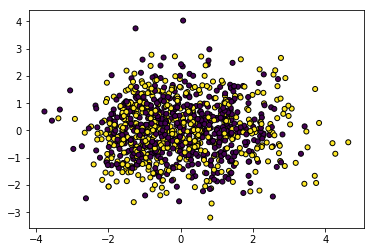

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
n_features = 10
X, label = datasets.samples_generator.make_classification(
    n_samples=1000, n_features=n_features, n_redundant=0, n_informative=2, n_clusters_per_class=2, flip_y=0.1, random_state=1)


plt.scatter(X[:, 0], X[:, 1], marker='o', c=label, s=25, edgecolor='k')

In [ ]:
import copy

class base(object):
    @staticmethod
    def tanh(x, derivative=False):
        return np.tanh(x) if derivative==False else np.arctanh(x)
    
    @staticmethod
    def relu(x, derivative=False):
        if derivative==False:
            return np.maximum(x, 0, x)
        else:
            _ = x.reshape( (np.prod(x.shape), ) )
            return np.array( [(1.0 if v>0 else 0.0) for v in _] ).reshape( x.shape )

    @staticmethod
    def sigmoid(x, derivative=False):
        f = lambda v: 1. / (1. + np.exp(-v))
        return f(x) if derivative==False else f(x) * f(1-x)
    
    @staticmethod
    def x_entropy(y_hat, y):
        EPS = 1e-6
        return -np.mean( np.log(y_hat+EPS) * y + np.log(1.-y_hat+EPS) * (1.0 - y) )


class model(base):
    def __init__(self, num_params=2, num_layers=3, activation=base.relu):
        self.activation = activation
        self.W = [np.random.uniform(-1.0, 1.0, (num_params, num_params)) for i in range(num_layers)]
        self.W.append( np.random.uniform(-1.0, 1.0, (num_params, 1)) )
        self._W = copy.deepcopy(self.W)
        self.outputs = []
        self.gradients = []
        
    def store(self):
        self._W = copy.deepcopy(self.W)
        
    def reset(self):
        self.W = copy.deepcopy(self._W)
        
    def forward(self, X):
        self.outputs = []
        self.gradients = []
        x = X
        for w in self.W[:-1]:
            a = np.dot(x, w)
            z = self.activation(a)
            self.outputs.append( {'x':x, 'a':a, 'z':z} )
            self.gradients.append( {'w':None} )
            x = z
        a = np.dot(x, self.W[-1])
        z = a
        self.outputs.append( {'x':x, 'a':a, 'z':z} )
        self.gradients.append( {'w':None} )
        return z
    
    def predcit(self, X):
        return base.sigmoid( self.forward(X) )
    
    def loss(self, X, y):
        return base.x_entropy( self.predcit(X), y)
    
    def backward(self, X, y):
        delta = self.forward(X) - y.reshape(-1, 1)
        delta_a = delta / (1.0 * y.shape[0])
        delta_x = np.dot(delta_a, self.W[-1].T)
        delta_z = delta_x
        
        delta_w = np.dot( self.outputs[-1]['x'].T, delta_a )
        self.gradients[-1]['w'] = delta_w

        reversed_index = reversed(range(len(self.W)-1))
        for index in reversed_index:
            W = self.W[index]
            x = self.outputs[index]['x']
            
            delta_a = delta_z * self.activation(self.outputs[index]['a'], derivative=True)
            delta_x = np.dot(delta_a, W.T)
            delta_z = delta_x

            delta_w = np.dot( self.outputs[index]['x'].T, delta_a )
            self.gradients[index]['w'] = delta_w
            
        return self